In [1]:
import numpy as np
import matplotlib.pyplot as plt
from phoebe.dependencies import distl
import phoebe
from astropy import units as u
from astropy import constants as c
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()
%matplotlib inline

In [2]:
lc_res = {
    'period@binary': phoebe.gaussian(51.418877, 2.6e-5),
    't0_supconj': phoebe.gaussian(2458696.019915, 7e-5),
    'requivsumfrac': phoebe.gaussian(0.070419, 0.0001),
    'requivratio': phoebe.gaussian(0.4659, 0.0031),
    'incl@binary': phoebe.gaussian(86.3632, 0.008),
    'sma@primary': phoebe.gaussian(44.521,0.07),
    'ld_coeffs[0]@primary': phoebe.gaussian(0.072,0.081),
    'ld_coeffs[1]@primary': phoebe.gaussian(0.487,0.12),
    'ld_coeffs[0]@secondary': phoebe.gaussian(0.365,0.126),
    'ld_coeffs[1]@secondary': phoebe.gaussian(0.121,0.194),
    'vgamma': phoebe.gaussian(-11.7,0.022),
    'teff@primary': phoebe.gaussian(9809,100),
    'logg@primary': phoebe.gaussian(3.63,0.20),
    'teffratio': phoebe.gaussian(1.051,0.009),
    'syncpar@primary': phoebe.gaussian(6.35,0.6),
    'syncpar@secondary': phoebe.gaussian(17.7,8),
    'q@binary': phoebe.gaussian(0.6653,0.007),
    'esinw': phoebe.gaussian(0.15586, 0.001),
    'ecosw': phoebe.gaussian(0.395055, 6.5e-5),
    'pblum@primary': phoebe.gaussian(10.216,0.032),
    'sigmas_lnf@lc01': phoebe.gaussian(-8.445, 0.016),
    'sigmas_lnf@primary@rv01': phoebe.gaussian(-4.89, 0.15),
}

Data:

In [3]:
lc_tess = np.loadtxt('data/lc_resampled.txt')
lc_tess[:,0] = lc_tess[:,0]+2457000
rv1_song = np.loadtxt('../data/SONG.txt')
rv1_song[:,0]=rv1_song[:,0]+2400000

Setup the PHOEBE bundle and all relevant parameters to compute a forward model with the ELLC backend and spherical geometry, to make sure that we still get a similar result as using pure ELLC (not interfacing with PHOEBE):

In [4]:
b = phoebe.default_binary()
b.add_dataset('lc', times=lc_tess[:,0], fluxes=lc_tess[:,1], sigmas=lc_tess[:,2], passband='TESS:T')
b.add_dataset('rv', component='primary', times=rv1_song[:,0], rvs=rv1_song[:,1], sigmas=rv1_song[:,2])

<ParameterSet: 81 parameters | contexts: figure, dataset, compute, constraint>

In [5]:
b.add_compute('ellc')
b.set_value_all('ld_mode', value='manual')
b.set_value_all('ld_func', value='square_root')
b.set_value_all('distortion_method', compute='ellc01', value='roche')
b.set_value_all('rv_method', compute='ellc01', value='flux-weighted')
# b.set_value_all('irrad_method', compute='ellc01', value='none')

In [6]:
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

In [7]:
b.flip_constraint('sma@primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {sma@primary@component} * ((1.000000 / {q@binary@component}) + 1.000000) (solar units) => 5.3 solRad>

In [8]:
b.set_value_all('gravb_bol', 1.0)
b.set_value_all('irrad_frac_refl_bol', 1.0)

To save us some time and unnecessary repeating of the same steps later, we'll also add the distributions to initialize from at the same time as setting the parameter values here (will be relevant later for the MCMC run):

In [9]:
ph_params = ['t0_supconj', 'period@binary', 'requivsumfrac', 'requivratio', 
             'incl@binary', 'esinw', 'ecosw', 'teff@primary', 'teffratio', 'q@binary',
             'sma@primary', 'vgamma', 'syncpar@primary', 'syncpar@secondary', 'pblum@primary',
            'sigmas_lnf@lc01', 'sigmas_lnf@primary@rv01']
for twig in ph_params:
    b.set_value(twig, lc_res[twig].loc)
    b.add_distribution(twig, lc_res[twig], distribution='sample_init')
    
b.set_value_all('ld_coeffs@primary', [0.072,0.487])
b.set_value_all('ld_coeffs@secondary', [0.365,0.121])

for twig in ['ld_coeffs[0]@primary', 'ld_coeffs[1]@primary', 'ld_coeffs[0]@secondary', 'ld_coeffs[1]@secondary']:
    b.add_distribution(twig, lc_res[twig], dataset='lc01', distribution='sample_init')

In [10]:
b.add_distribution('t0_supconj', phoebe.uniform(2458695,2458697), distribution='upriors')
b.add_distribution('period@binary', phoebe.uniform(50.4,52.4), distribution='upriors')
b.add_distribution('esinw', phoebe.uniform(-1.,1), distribution='upriors')
b.add_distribution('ecosw', phoebe.uniform(-1.,1), distribution='upriors')
b.add_distribution('q', lc_res['q@binary'], distribution='upriors')
b.add_distribution('incl@binary', phoebe.uniform(80,90), distribution='upriors')
b.add_distribution('requivsumfrac', phoebe.uniform(0.001,0.1), distribution='upriors')
b.add_distribution('requivratio', phoebe.uniform(0.10,0.90), distribution='upriors')
b.add_distribution('teff@primary', lc_res['teff@primary'], distribution='upriors')
b.add_distribution('teffratio', phoebe.uniform(0.01, 1.5), distribution='upriors')
b.add_distribution('sma@primary', lc_res['sma@primary'], distribution='upriors')
b.add_distribution('vgamma', lc_res['vgamma'], distribution='upriors')
b.add_distribution('pblum@primary', phoebe.uniform(2,20), distribution='upriors', allow_multiple_matches=True)
b.add_distribution('syncpar@primary', phoebe.uniform(0.01,10), distribution='upriors')
b.add_distribution('syncpar@secondary', phoebe.uniform(0.01,100), distribution='upriors')
b.add_distribution('sigmas_lnf@lc01', phoebe.uniform(-13,1), distribution='upriors')
b.add_distribution('ld_coeffs@lc01', phoebe.uniform(0,1), 
                   distribution='upriors', allow_multiple_matches=True)
b.add_distribution('sigmas_lnf@primary@rv01', lc_res['sigmas_lnf@primary@rv01'], distribution='upriors')
b.add_distribution('ld_coeffs@primary@rv01', phoebe.uniform(0,1), 
                   distribution='upriors', allow_multiple_matches=True)

b.add_distribution('logg@primary', phoebe.gaussian(3.63,0.20), distribution='upriors')
b.add_distribution('mass@secondary', phoebe.uniform(1.5,3.0), distribution='upriors')
b.add_distribution('requiv@secondary', phoebe.uniform(1.5,3.0), distribution='upriors')

<ParameterSet: 1 parameters>

In [11]:
# b.set_value_all('pblum_mode', 'dataset-scaled')
%matplotlib qt
b.run_checks()
b.run_delayed_constraints()
b.run_compute('ellc01')
b.plot(x='phase', s=0.01, show=True)

100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 1152x1728 with 2 Axes>)

### MCMC setup

Let's see our final initial sample distribution and make sure all relevant parameters are included:

In [12]:
print(b['sample_init'])

ParameterSet: 21 parameters
   t0_supconj@sample_init@dist...: <distl.gaussian loc=2458696.019915 scale=7e-05 unit=d>
   period@sample_init@distribu...: <distl.gaussian loc=51.418877 scale=2.6e-05 unit=d>
   requivsumfrac@sample_init@d...: <distl.gaussian loc=0.070419 scale=0.0001 unit=>
   requivratio@sample_init@dis...: <distl.gaussian loc=0.4659 scale=0.0031 unit=>
    incl@sample_init@distribution: <distl.gaussian loc=86.3632 scale=0.008 unit=deg>
   esinw@sample_init@distribution: <distl.gaussian loc=0.15586 scale=0.001 unit=>
   ecosw@sample_init@distribution: <distl.gaussian loc=0.395055 scale=6.5e-05 unit=>
    teff@sample_init@distribution: <distl.gaussian loc=9809.0 scale=100.0 unit=K>
   teffratio@sample_init@distr...: <distl.gaussian loc=1.051 scale=0.009 unit=>
       q@sample_init@distribution: <distl.gaussian loc=0.6653 scale=0.007 unit=>
     sma@sample_init@distribution: <distl.gaussian loc=44.521 scale=0.07 unit=solRad>
   vgamma@sample_init@distribu...: <distl.gaussi

In [13]:
print(b['upriors'])

ParameterSet: 26 parameters
   t0_supconj@upriors@distribu...: <distl.uniform low=2458695.0 high=2458697.0 unit=d>
      period@upriors@distribution: <distl.uniform low=50.4 high=52.4 unit=d>
       esinw@upriors@distribution: <distl.uniform low=-1.0 high=1.0 unit=>
       ecosw@upriors@distribution: <distl.uniform low=-1.0 high=1.0 unit=>
           q@upriors@distribution: <distl.gaussian loc=0.6653 scale=0.007 unit=>
        incl@upriors@distribution: <distl.uniform low=80.0 high=90.0 unit=deg>
   requivsumfrac@upriors@distr...: <distl.uniform low=0.001 high=0.1 unit=>
   requivratio@upriors@distrib...: <distl.uniform low=0.1 high=0.9 unit=>
        teff@upriors@distribution: <distl.gaussian loc=9809.0 scale=100.0 unit=K>
   teffratio@upriors@distribution: <distl.uniform low=0.01 high=1.5 unit=>
         sma@upriors@distribution: <distl.gaussian loc=44.521 scale=0.07 unit=solRad>
      vgamma@upriors@distribution: <distl.gaussian loc=-11.7 scale=0.022 unit=km / s>
       pblum@uprior

### prepare for MCMC and go!

In [14]:
b.add_solver('sampler.emcee', solver='myemcee',
              init_from='sample_init',
              priors='upriors', 
              compute='ellc01', nwalkers=96, niters=50000, progress_every_niters=100)
b.save("adra_paper_lc_rv_irradfix2.bundle")
b.export_solver('adra_paper_lc_rv_irradfix2.py', solver='myemcee')

('adra_paper_lc_rv_irradfix2.py', 'adra_paper_lc_rv_irradfix2.py.out')

In [15]:
!scp adra_paper_lc_rv_irradfix2.py angela@terra.villanova.edu:fitting/adra_2021

adra_paper_lc_rv_irradfix2.py                 100%  324KB   2.6MB/s   00:00    


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from phoebe.dependencies import distl
import phoebe
from astropy import units as u
from astropy import constants as c
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

In [4]:
!scp angela@terra.villanova.edu:fitting/adra_2021/adra_paper_lc_rv_irradfix2.py.out.progress .

adra_paper_lc_rv_irradfix2.py.out.progress    100%  645MB  48.8MB/s   00:13    


In [5]:
b = phoebe.load('adra_paper_lc_rv_irradfix2.bundle', import_from_newer=True)
b.import_solution(r'adra_paper_lc_rv_irradfix2.py.out.progress', solution='lc_progress')
# %matplotlib inline
# afig, mplfig = b.plot(solution='lc_progress', burnin=0, thin=1, lnprob_cutoff = -np.inf, s=0.005, show=True)

<ParameterSet: 20 parameters | qualifiers: failed_samples, wrap_central_values, adopt_parameters, burnin, fitted_units, imported_job, fitted_twigs, thin, lnprob_cutoff, adopt_distributions, niters, autocorr_times, distributions_convert, adopt_values, progress, acceptance_fractions, fitted_uniqueids, nwalkers, samples, lnprobabilities>

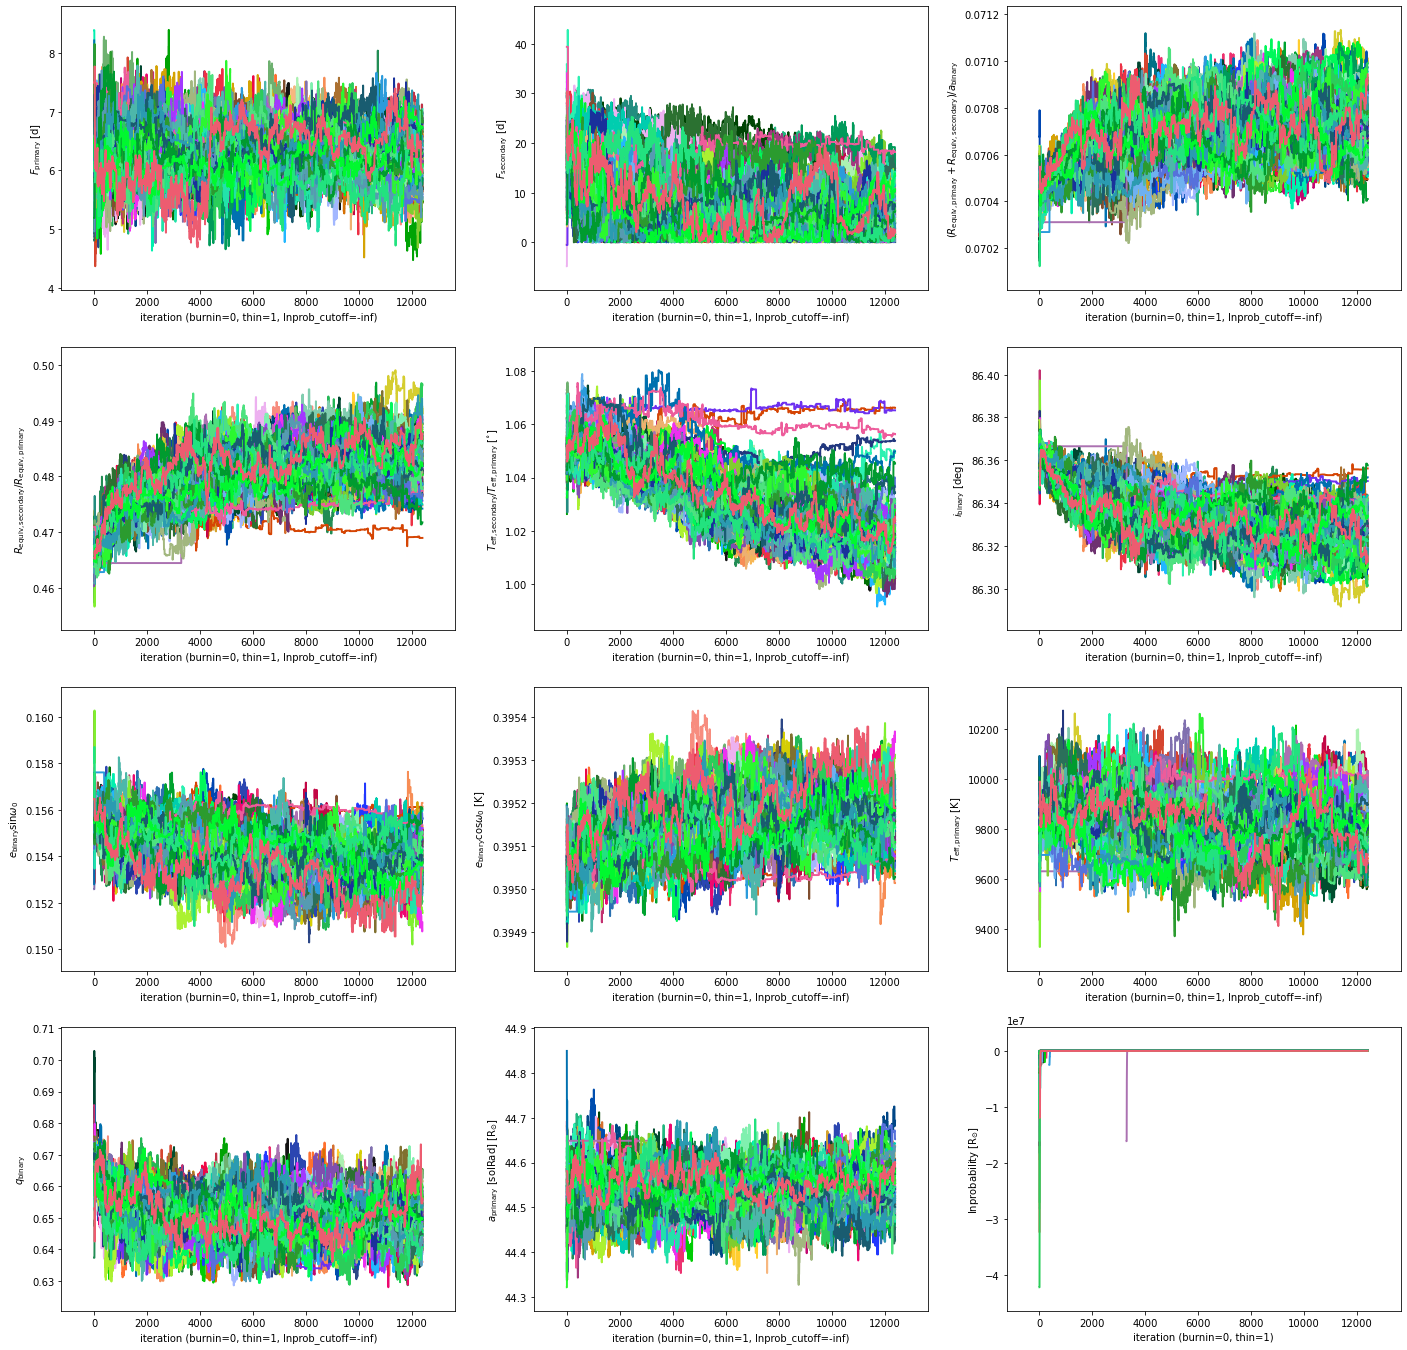

In [4]:
%matplotlib inline
afig, mplfig = b.plot(
    adopt_parameters=['syncpar*','requivsumfrac', 'requivratio', 'teffratio', 'incl@binary','esinw', 'ecosw', 'teff@primary', 'q', 'sma@primary'],
#     adopt_parameters=['syncpar*'],
    solution='lc_progress', burnin=0, thin=1, lnprob_cutoff = -np.inf, s=0.005, show=True)

Clean-up walkers to remove several that seem stuck in a local minimum close to the global one:

In [33]:
np.argwhere(b['value@samples@lc_progress'][:,:,8][-1] > 1.05)

array([[13],
       [19],
       [21],
       [38],
       [81]])

In [38]:
b['value@samples@lc_progress'].shape

(12500, 96, 21)

In [42]:
b['value@lnprobabilities@lc_progress'].shape

(12500, 96)

In [45]:
samples_clean = b['value@samples@lc_progress']
lnprobs_clean = b['value@lnprobabilities@lc_progress']
samples_clean = np.delete(samples_clean, [13,19,21,38,81], axis=1)
lnprobs_clean = np.delete(lnprobs_clean, [13,19,21,38,81], axis=1)
print(samples_clean.shape, lnprobs_clean.shape)

b.set_value('samples@lc_progress', value = samples_clean, ignore_readonly=True)
b.set_value('lnprobabilities@lc_progress', value = lnprobs_clean, ignore_readonly=True)

(12500, 91, 21) (12500, 91)


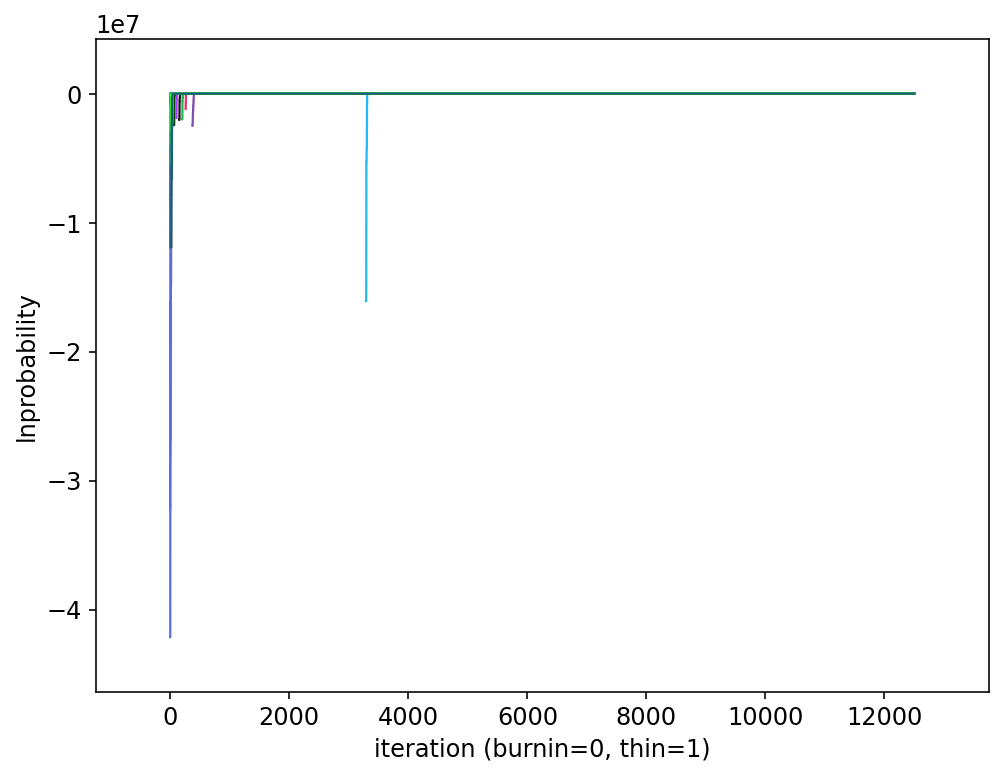

In [47]:
%matplotlib qt
afig, mplfig = b.plot(solution='lc_progress',style='lnprobability', burnin=0, thin=1, lnprob_cutoff = -np.inf, s=0.005, show=True)

<Figure size 432x288 with 0 Axes>

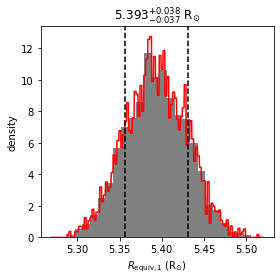

<Figure size 432x288 with 0 Axes>

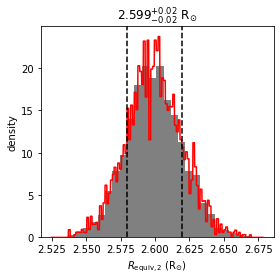

<Figure size 432x288 with 0 Axes>

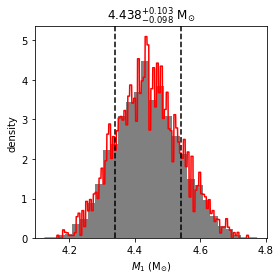

<Figure size 432x288 with 0 Axes>

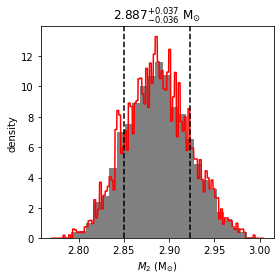

In [48]:
%matplotlib inline
dist = b.get_parameter('requiv', component='primary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

dist = b.get_parameter('requiv', component='secondary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

dist = b.get_parameter('mass', component='primary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()


dist = b.get_parameter('mass', component='secondary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

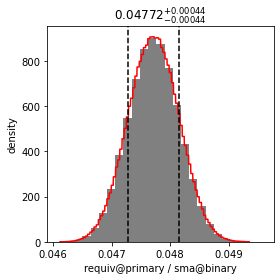

<Figure size 432x288 with 0 Axes>

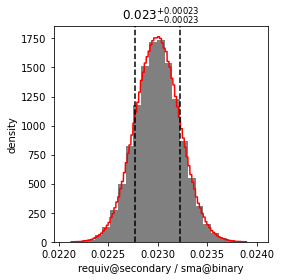

In [49]:
dist_sma = b.get_parameter('sma', component='binary', context='component').get_distribution('lc_progress')
dist_r1 = b.get_parameter('requiv', component='primary', context='component').get_distribution('lc_progress')
dist_r2 = b.get_parameter('requiv', component='secondary', context='component').get_distribution('lc_progress')

dist_r1frac = dist_r1/dist_sma
plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist_r1frac.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

dist_r2frac = dist_r2/dist_sma
plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist_r2frac.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

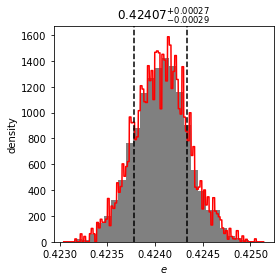

<Figure size 432x288 with 0 Axes>

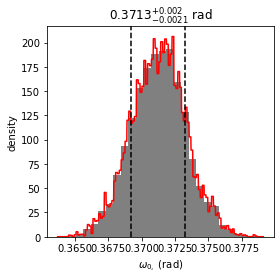

<Figure size 432x288 with 0 Axes>

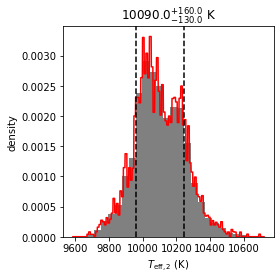

In [50]:
dist = b.get_parameter('ecc', component='binary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

b.set_default_unit_all('per0', 'rad')
dist = b.get_parameter('per0', component='binary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

dist = b.get_parameter('teff', component='secondary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

<Figure size 252x189 with 0 Axes>

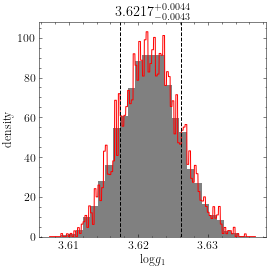

In [56]:
dist = b.get_parameter('logg', component='primary', context='component').get_distribution('lc_progress')

plt.clf()
figure = plt.figure(figsize=(4,4))
_ = dist.plot(plot_uncertainties=True)
_ =plt.tight_layout()
plt.show()

In [10]:
b.adopt_solution(solution='lc_progress', burnin=7000, lnprob_cutoff = 0, thin=1)

<ParameterSet: 69 parameters | contexts: component, dataset, system, distribution>

In [6]:
b.run_compute(compute='ellc01', model='ph2ellc_model', overwrite=True)

100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


<ParameterSet: 5 parameters | kinds: rv, lc>

In [35]:
%matplotlib qt
b.plot(x='phase', s=0.01, model='ph2ellc_model', show=True)

(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 1152x1728 with 2 Axes>)

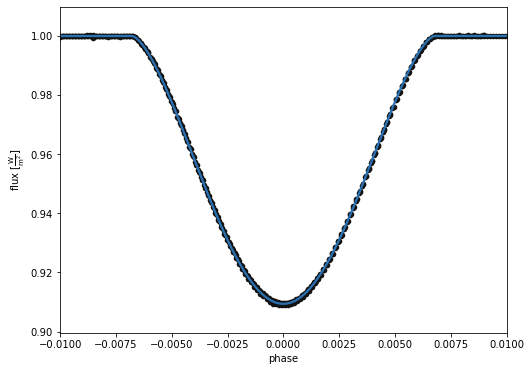

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


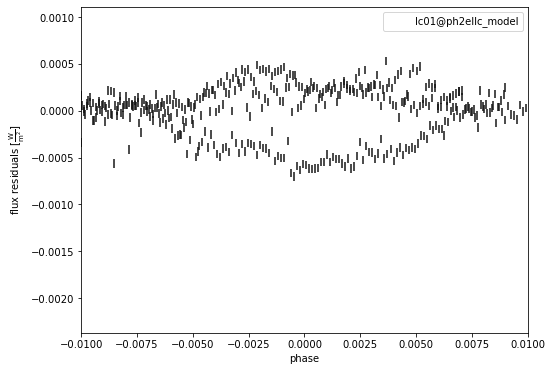

In [36]:
%matplotlib inline
b.plot(kind='lc', model='ph2ellc_model', x='phases', y='fluxes', 
           s={'dataset': 0.025},
           marker={'dataset': '.'}, xlim=((-0.01,0.01)), show=True)
_ = b.plot(kind='lc', model='ph2ellc_model', x='phases', y='residuals', 
           z={'dataset': 0, 'model': 1}, xlim=((-0.01,0.01)), legend=True,
         show=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


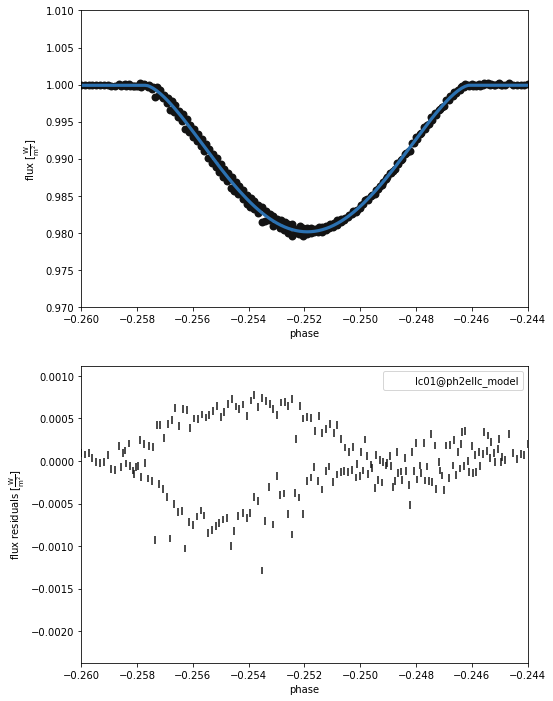

In [37]:
%matplotlib inline
_ = b.plot(kind='lc', model='ph2ellc_model', x='phases', y='fluxes', 
           s={'dataset': 0.025},
           marker={'dataset': '.'}, xlim=((-0.26,-0.244)), ylim=((0.97,1.01)))
_ = b.plot(kind='lc', model='ph2ellc_model', x='phases', y='residuals', 
           z={'dataset': 0, 'model': 1}, xlim=((-0.26,-0.244)), legend=True,
         show=True)

### Paper results and plots

In [55]:
b.uncertainties_from_distribution_collection('lc_progress', 
                                             burnin=7000, thin=1, tex=True)

t0_supconj@binary = 2458696.019904 +6.4e-05 -6.6e-05  d
period@binary = 51.418881 +2.4e-05 -2.5e-05  d
requivsumfrac@binary = 0.07073 +0.00012 -0.00013  
requivratio@binary = 0.4829 +0.0039 -0.0038  
incl@binary = 86.3276 +0.0105 -0.0092  deg
esinw@binary = 0.15374 +0.00088 -0.00092  
ecosw@binary = 0.395177 +5.6e-05 -5.6e-05  
teff@primary = 9831.0 +88.0 -105.0  K
teffratio@binary = 1.0211 +0.0097 -0.0079  
q@binary = 0.6502 +0.0065 -0.0065  
sma@primary = 44.539 +0.044 -0.042  solRad
vgamma = -11.706 +0.017 -0.017  km / s
syncpar@primary = 6.37 +0.36 -0.4  
syncpar@secondary = 5.7 +5.7 -4.0  
pblum@lc01 = 10.091 +0.034 -0.035  W
sigmas_lnf@lc01 = -8.453 +0.012 -0.012  
sigmas_lnf@rv01 = -5.02 +0.12 -0.11  
ld_coeffs[0]@lc01 = 0.24 +0.11 -0.14  
ld_coeffs[1]@lc01 = 0.27 +0.23 -0.18  
ld_coeffs[0]@lc01 = 0.318 +0.044 -0.058  
ld_coeffs[1]@lc01 = 0.057 +0.095 -0.042  

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('science')
import matplotlib
matplotlib.rcParams['font.size'] = 8

fig, axes = plt.subplots(2, 1, figsize=[3.36, 4], gridspec_kw={'height_ratios': [1, 0.7]})
fig.set_rasterized(True)
b.plot(kind='lc', dataset='lc01', model='ph2ellc_model_full', x='phases', y='fluxes', 
           s={'dataset': 0.025, 'model': 0.025}, xlim=((-0.27,0.02)),
           marker={'dataset': '.'}, ax=axes[0], draw=True)
b.plot(kind='lc', s=0.0001, model='ph2ellc_model_full', x='phases', y='residuals', 
           z={'dataset': 0, 'model': 1}, xlim=((-0.27,0.02)), ax=axes[1], draw=True)

axins = axes[0].inset_axes([0.15, 0.15, 0.5, 0.5])
b.plot(kind='lc', dataset='lc01', model='ph2ellc_model_full', x='phases', y='fluxes', 
           s={'dataset': 0.025, 'model': 0.025}, xlim=((-0.18,-0.02)),
           marker={'dataset': '.'}, ax=axins, draw=True)

axins.set_xlim(-0.18,-0.02)
axins.set_ylim(0.9975,1.0015)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlabel('')
axins.set_ylabel('')

axes[0].set_xlabel('')
axes[0].set_xticklabels('')
axes[0].indicate_inset_zoom(axins)
axes[1].axhline(0., c='red', linestyle='dashed')
axes[0].set_ylabel('Flux')
axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('Phase')

fig.subplots_adjust(hspace=0.05)
fig.tight_layout()

fig.savefig('plots/' + 'lc_fit_phoebe.pdf', dpi=300)

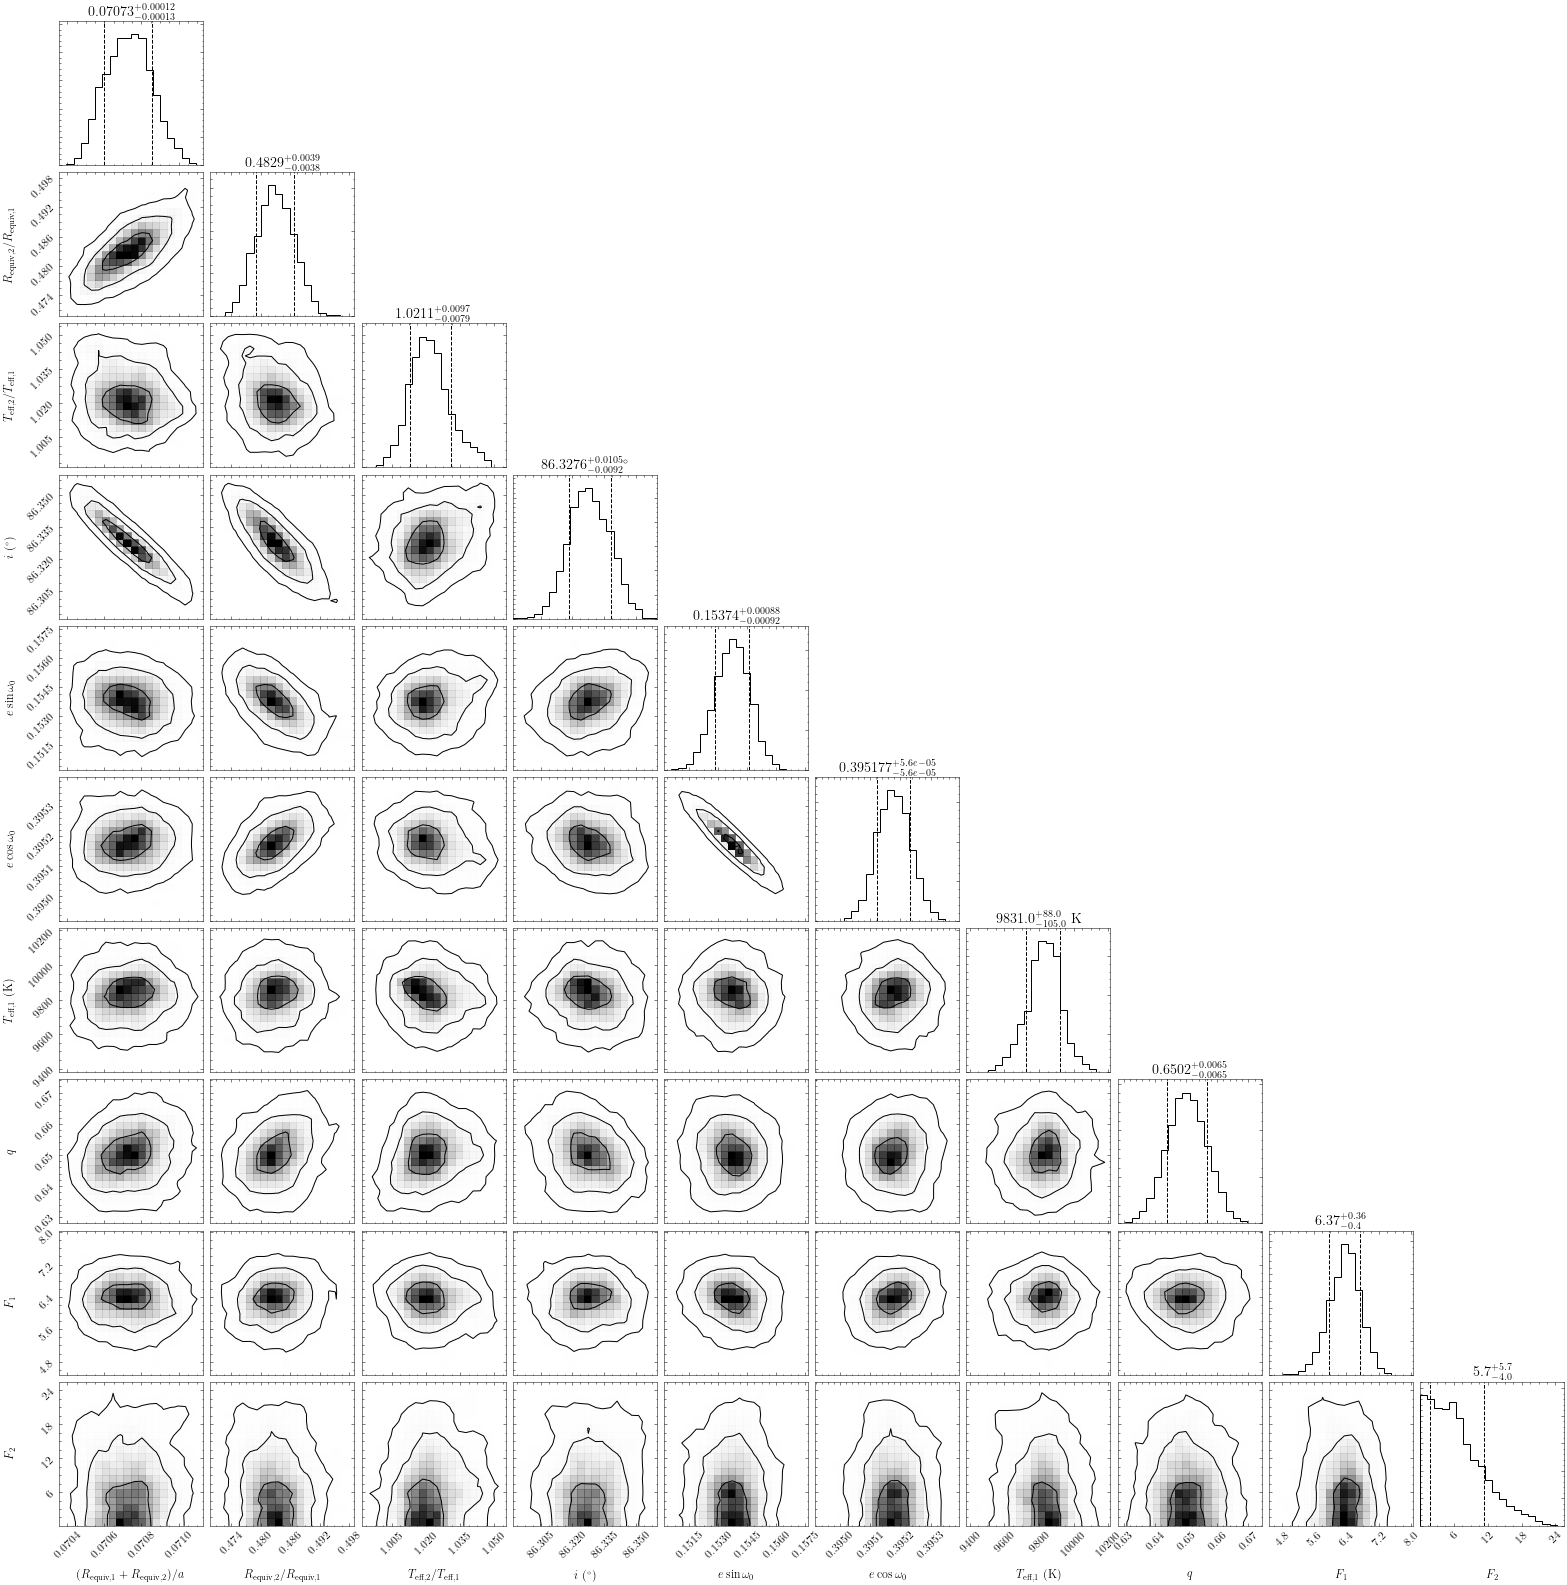

In [53]:
matplotlib.rcParams['font.size'] = 12

b.set_value('latex_repr', component='binary', value=' ')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

afig, mplfig = b.plot(style='corner', 
                      adopt_parameters=[
                          'requivsumfrac', 'requivratio', 
                                        'teffratio', 
                          'incl@binary','esinw', 'ecosw', 
                                        'teff@primary', 'q',
                                       'syncpar@primary', 'syncpar@secondary'],
#                       distributions_convert='mvgaussian',
                      solution='lc_progress', 
                      burnin=7000, thin=1, lnprob_cutoff = 29000, rasterized=True,
                      show_titles=True, 
                      smooth=0.5, 
                      quantiles=[0.16, 0.5, 0.84], 
                      fill_contours=False, 
                      plot_datapoints=False);

In [54]:
mplfig.set_size_inches(15.28,15.28)
mplfig.savefig('plots/corner_phoebe.pdf', dpi=300)